# Board Detection via Gradient Projection + End-to-End FEN Pipeline

## Approach (adapted from [chessboard-recogniser](https://github.com/kratos606/chessboard-recogniser))

1. **Histogram equalization** on grayscale, normalize to float
2. **Sobel gradients** (large kernel, ksize=31) to highlight grid edges while suppressing piece detail
3. **Positive/negative gradient product**: sum positive and negative gradients separately along each axis, multiply them — grid lines have both dark-to-light and light-to-dark transitions, so only real grid lines produce strong peaks
4. **Adaptive thresholding** + Gaussian blur + skeletonization to find peak positions
5. **Prune lines** to find 7 equally-spaced interior lines in each direction
6. **Extend outward** by one step to get the 9 boundary lines (full board edges)
7. **ML model prediction** on cropped board squares → FEN notation
8. **Generate analysis links** (Lichess, Chess.com)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io, transform
from skimage.util.shape import view_as_blocks
from itertools import combinations
import os
import urllib.parse
import keras
import tensorflow as tf

SCREENSHOTS_DIR = 'data/screenshots'
MODEL_PATH = 'models/ensemble_medium.keras'
SQUARE_SIZE = 40

print('Imports loaded')

2026-02-05 16:57:04.122273: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 16:57:04.129960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-05 16:57:04.466125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 16:57:08.097040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Imports loaded


## Helper Functions

In [2]:
def gradientx(img):
    """Compute gradient in x-direction using large Sobel kernel (ksize=31).
    Large kernel smooths out piece-level detail, emphasizing board grid lines."""
    return cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=31)

def gradienty(img):
    """Compute gradient in y-direction using large Sobel kernel (ksize=31)."""
    return cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=31)

def skeletonize_1d(arr):
    """Non-maximum suppression on a 1D signal. Keeps only local maxima,
    zeros out everything else to produce clean peak positions."""
    _arr = arr.copy()
    for i in range(len(_arr) - 1):
        if _arr[i] <= _arr[i + 1]:
            _arr[i] = 0
    for i in range(len(_arr) - 1, 0, -1):
        if _arr[i - 1] > _arr[i]:
            _arr[i] = 0
    return _arr

def checkMatch(lineset, tol_frac=0.06):
    """Check if a set of lines has 6 consecutive approximately-equal-spaced diffs.
    Uses relative tolerance: each diff must be within tol_frac of the running average."""
    if len(lineset) < 7:
        return False
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        tol = max(5, x * tol_frac) if x > 0 else 5
        if abs(line - x) < tol:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt >= 5

def pruneLines(lineset, image_dim, margin=10):
    """Remove lines near image margins and find the 7 consecutive equally-spaced
    lines that form the interior grid of a chessboard.
    Uses relative tolerance for spacing comparison."""
    lineset = [x for x in lineset if x > margin and x < image_dim - margin]
    if len(lineset) < 7:
        return lineset
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        tol = max(5, x * 0.06) if x > 0 else 5
        if abs(line - x) < tol:
            cnt += 1
            if cnt == 5:
                end_pos = i + 2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            start_pos = i
    return lineset

def fillMissingLines(lineset, image_dim, margin=10):
    """If we have 6 lines with 5 consistent diffs where one gap is ~2x the spacing,
    interpolate the missing line to get 7 equally-spaced lines."""
    lineset = [x for x in lineset if x > margin and x < image_dim - margin]
    if len(lineset) < 6:
        return lineset
    
    linediff = np.diff(lineset)
    
    # Find runs of consistent spacing
    for start in range(len(linediff)):
        if start + 4 > len(linediff):
            break
        # Check if we can find at least 4 consistent diffs starting here
        segment_diffs = linediff[start:start+5] if start + 5 <= len(linediff) else linediff[start:]
        if len(segment_diffs) < 4:
            continue
        
        median_step = np.median(segment_diffs[segment_diffs < np.median(segment_diffs) * 1.5])
        
        # Count consistent and find the double-gap
        consistent = 0
        double_idx = -1
        for j, d in enumerate(segment_diffs):
            if abs(d - median_step) < median_step * 0.08:
                consistent += 1
            elif abs(d - 2 * median_step) < median_step * 0.15:
                double_idx = j
            
        if consistent >= len(segment_diffs) - 1 and double_idx >= 0:
            # Interpolate the missing line
            insert_pos = start + double_idx + 1
            missing_val = int(round(lineset[insert_pos - 1] + median_step))
            new_lines = lineset[:insert_pos] + [missing_val] + lineset[insert_pos:]
            return new_lines
    
    return lineset

def _score_board_candidate(bw, bh, image_area):
    """Score a contour candidate for board likelihood (lower = better).
    
    Uses quadratic aspect penalty so extreme rectangles are penalized steeply,
    with a size bonus so larger contours are preferred among similar aspects.
    This ensures the digital board (large, roughly square) beats small incidental
    square regions (e.g. camera feeds) and large wide rectangles (e.g. full frame).
    """
    aspect = bw / bh if bh > 0 else 0
    aspect_penalty = (1.0 - aspect) ** 2
    area_frac = (bw * bh) / image_area
    return aspect_penalty - 0.5 * area_frac

def _find_best_board_contour(contours, image_area, min_area_frac):
    """From a list of contours, find the best board candidate above the area threshold.
    
    Scores candidates by a combination of squareness and size.
    Returns (bx, by, bw, bh) or None.
    """
    best = None
    best_score = float('inf')
    for cnt in contours[:20]:
        bx, by, bw, bh = cv2.boundingRect(cnt)
        area = bw * bh
        if area < min_area_frac * image_area:
            continue
        aspect = bw / bh if bh > 0 else 0
        # Reject extreme rectangles
        if aspect < 0.5 or aspect > 2.0:
            continue
        score = _score_board_candidate(bw, bh, image_area)
        if score < best_score:
            best_score = score
            best = (bx, by, bw, bh)
    return best

def rough_crop_board(image, min_area_frac=0.05, padding_frac=0.02):
    """Contour-based rough crop to isolate the board region before gradient projection.
    
    Multi-strategy approach:
    1. Canny + morphological closing + RETR_EXTERNAL (original)
    2. Canny + morphological closing + RETR_TREE (finds nested contours)
    3. Canny without closing + RETR_EXTERNAL (fallback for dense layouts)
    
    Candidates are scored by a combination of squareness (quadratic penalty)
    and size — among similarly-square contours, larger ones are preferred
    (the digital board is typically larger than incidental square regions).
    
    Returns:
        (cropped_image, (y_offset, x_offset), found_bool)
    """
    h, w = image.shape[:2]
    image_area = h * w
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image.copy()
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Morphological closing to merge nearby edges — kernel scales with image size
    k_size = max(10, min(h, w) // 80)
    kernel = np.ones((k_size, k_size), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Strategy 1: closed edges, external contours only
    contours_ext, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_ext = sorted(contours_ext, key=cv2.contourArea, reverse=True)
    
    # Strategy 2: closed edges, tree hierarchy (finds nested contours like board inside UI)
    contours_tree, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_tree = sorted(contours_tree, key=cv2.contourArea, reverse=True)
    
    # Strategy 3: raw Canny edges without closing (board grid lines stay separate)
    contours_raw, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_raw = sorted(contours_raw, key=cv2.contourArea, reverse=True)
    
    # Find best candidate from each strategy, then pick overall best
    candidates = []
    for contours in [contours_ext, contours_tree, contours_raw]:
        result = _find_best_board_contour(contours, image_area, min_area_frac)
        if result is not None:
            candidates.append(result)
    
    if not candidates:
        return image, (0, 0), False
    
    # Pick overall best by combined score
    best = min(candidates, key=lambda c: _score_board_candidate(c[2], c[3], image_area))
    
    bx, by, bw, bh = best
    # Add padding, clamp to image bounds
    pad_x = int(padding_frac * bw)
    pad_y = int(padding_frac * bh)
    y0 = max(0, by - pad_y)
    y1 = min(h, by + bh + pad_y)
    x0 = max(0, bx - pad_x)
    x1 = min(w, bx + bw + pad_x)
    
    cropped = image[y0:y1, x0:x1]
    return cropped, (y0, x0), True

print('gradientx, gradienty, skeletonize_1d, checkMatch, pruneLines, fillMissingLines, rough_crop_board defined')

gradientx, gradienty, skeletonize_1d, checkMatch, pruneLines, fillMissingLines, rough_crop_board defined


In [3]:
def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh, image_shape):
    """Detect 7 horizontal and 7 vertical interior chessboard lines.
    
    Thresholds the Hough-like projection signals, applies Gaussian blur
    to merge nearby peaks, skeletonizes to find exact positions, then
    prunes to find the 7 equally-spaced lines.
    
    If only 6 lines are found with one double-gap, interpolates the missing line.
    
    Returns:
        lines_x: list of x-positions of vertical lines
        lines_y: list of y-positions of horizontal lines
        is_match: True if exactly 7+7 equally-spaced lines found
    """
    # Gaussian window for blurring the thresholded signal
    window_size = 21
    sigma = 8.0
    gausswin = cv2.getGaussianKernel(window_size, sigma, cv2.CV_64F).flatten()

    # Threshold signals to binary
    hdx_binary = np.where(hdx > hdx_thresh, 1.0, 0.0)
    hdy_binary = np.where(hdy > hdy_thresh, 1.0, 0.0)

    # Blur to merge nearby peaks
    blur_x = np.convolve(hdx_binary, gausswin, mode='same')
    blur_y = np.convolve(hdy_binary, gausswin, mode='same')

    # Skeletonize to get exact peak positions
    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Extract line positions
    lines_x = np.where(skel_x > 0)[0].tolist()
    lines_y = np.where(skel_y > 0)[0].tolist()

    # Try pruning to find 7 equally-spaced lines
    lines_x = pruneLines(lines_x, image_shape[1])
    lines_y = pruneLines(lines_y, image_shape[0])

    # If pruning didn't find 7, try filling a missing line (double-gap recovery)
    if len(lines_x) != 7 or not checkMatch(lines_x):
        raw_x = np.where(skel_x > 0)[0].tolist()
        lines_x = fillMissingLines(raw_x, image_shape[1])
        lines_x = pruneLines(lines_x, image_shape[1])
    
    if len(lines_y) != 7 or not checkMatch(lines_y):
        raw_y = np.where(skel_y > 0)[0].tolist()
        lines_y = fillMissingLines(raw_y, image_shape[0])
        lines_y = pruneLines(lines_y, image_shape[0])

    is_match = (len(lines_x) == 7) and (len(lines_y) == 7) and \
               checkMatch(lines_x) and checkMatch(lines_y)

    return lines_x, lines_y, is_match

print('getChessLines defined')

getChessLines defined


In [4]:
def detect_board(image_path, visualize=True):
    """
    Detect chessboard via gradient projection with pos/neg product.
    
    Pipeline:
    0. Rough contour-based crop to isolate board region
    1. Histogram equalization + normalize to float
    2. Large-kernel Sobel gradients (ksize=31)
    3. Positive/negative gradient product along each axis
    4. Adaptive threshold loop to find 7+7 interior grid lines
       (with refinement: if match found at lowest threshold, try next
       threshold too and prefer it — filters out weak spurious edges
       like evaluation bars)
    5. Extend outward by one step to get full board edges
    6. Crop exactly to board edges
    
    Returns:
        cropped: The cropped board image (RGB)
        bbox: (y0, y1, x0, x1) final bounding box in original image coordinates
    """
    print('=' * 60)
    print(f'BOARD DETECTION: {os.path.basename(image_path)}')
    print('=' * 60)
    
    image = io.imread(image_path)
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]
    h, w = image.shape[:2]
    print(f'Image size: {w}x{h}')

    # Rough crop to isolate board region before gradient projection
    cropped_rough, (y_off, x_off), crop_found = rough_crop_board(image)
    if crop_found:
        print(f'  Rough crop: offset=({x_off},{y_off}), size={cropped_rough.shape[1]}x{cropped_rough.shape[0]}')
        image = cropped_rough
        h, w = image.shape[:2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Histogram equalization + normalize to float
    equ = cv2.equalizeHist(gray)
    norm_image = equ.astype(np.float32) / 255.0
    
    # Compute gradients with large Sobel kernel
    grad_x = gradientx(norm_image)
    grad_y = gradienty(norm_image)
    
    # Split into positive and negative gradients
    Dx_pos = np.clip(grad_x, 0, None).astype(np.float64)
    Dx_neg = np.clip(-grad_x, 0, None).astype(np.float64)
    Dy_pos = np.clip(grad_y, 0, None).astype(np.float64)
    Dy_neg = np.clip(-grad_y, 0, None).astype(np.float64)
    
    # Hough-like projection: multiply positive and negative sums
    # Grid lines have both dark-to-light and light-to-dark transitions,
    # so only real grid lines produce strong peaks in the product
    hough_Dx = (np.sum(Dx_pos, axis=0) * np.sum(Dx_neg, axis=0)) / (h ** 2)
    hough_Dy = (np.sum(Dy_pos, axis=1) * np.sum(Dy_neg, axis=1)) / (w ** 2)
    
    # Adaptive threshold loop: try thresholds from 20% to 80% of max
    is_match = False
    lines_x = []
    lines_y = []
    a = 1
    
    while a < 5:
        threshold_x = np.max(hough_Dx) * (a / 5.0)
        threshold_y = np.max(hough_Dy) * (a / 5.0)
        
        lines_x, lines_y, is_match = getChessLines(
            hough_Dx, hough_Dy, threshold_x, threshold_y, norm_image.shape
        )
        
        if is_match:
            # Refinement: if we matched at the lowest threshold, also try the
            # next level up. A higher threshold filters out weak spurious edges
            # (e.g. evaluation bars) that can accidentally match the grid spacing.
            # Prefer the higher threshold result when available.
            if a < 4:
                next_thresh_x = np.max(hough_Dx) * ((a + 1) / 5.0)
                next_thresh_y = np.max(hough_Dy) * ((a + 1) / 5.0)
                next_lx, next_ly, next_match = getChessLines(
                    hough_Dx, hough_Dy, next_thresh_x, next_thresh_y, norm_image.shape
                )
                if next_match:
                    print(f'  Match found at threshold level {a}/5, refined to {a+1}/5')
                    lines_x, lines_y = next_lx, next_ly
                    a += 1
                else:
                    print(f'  Match found at threshold level {a}/5')
            else:
                print(f'  Match found at threshold level {a}/5')
            break
        a += 1
    
    if not is_match:
        print('FAILED: Could not find 7+7 equally-spaced grid lines.')
        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            axes[0].imshow(image)
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].plot(hough_Dx)
            axes[1].set_title(f'Hough Dx (vertical lines) - {len(lines_x)} found')
            axes[2].plot(hough_Dy)
            axes[2].set_title(f'Hough Dy (horizontal lines) - {len(lines_y)} found')
            plt.tight_layout()
            plt.show()
        return image, (y_off, h + y_off, x_off, w + x_off)
    
    # Compute step sizes from the 7 interior lines
    stepx = int(round(np.mean(np.diff(lines_x))))
    stepy = int(round(np.mean(np.diff(lines_y))))
    
    # Build the full 9 lines (outer edges + 7 interior)
    all_x = [lines_x[0] - stepx] + lines_x + [lines_x[-1] + stepx]
    all_y = [lines_y[0] - stepy] + lines_y + [lines_y[-1] + stepy]
    
    # Crop bbox: exactly on the outer grid edges
    x0 = max(0, all_x[0])
    x1 = min(w, all_x[-1])
    y0 = max(0, all_y[0])
    y1 = min(h, all_y[-1])
    
    print(f'  Interior lines: 7x + 7y, step={stepx}x{stepy} px')
    print(f'  Board bbox: y=[{y0},{y1}], x=[{x0},{x1}]')
    
    cropped = image[y0:y1, x0:x1]
    print(f'  Cropped: {cropped.shape[1]}x{cropped.shape[0]} px')
    
    # Offset bbox back to original image coordinates
    y0 += y_off; y1 += y_off; x0 += x_off; x1 += x_off
    
    if visualize:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Top-left: Hough Dx profile with detected lines
        axes[0, 0].plot(hough_Dx, 'b-', linewidth=0.5)
        for lx in lines_x:
            axes[0, 0].axvline(x=lx, color='cyan', alpha=0.5, linewidth=1)
        for lx in [all_x[0], all_x[-1]]:
            axes[0, 0].axvline(x=lx, color='lime', alpha=0.8, linewidth=2)
        axes[0, 0].set_title('Hough Dx (vertical lines)', fontsize=11, fontweight='bold')
        
        # Top-middle: Hough Dy profile with detected lines
        axes[0, 1].plot(hough_Dy, range(len(hough_Dy)), 'b-', linewidth=0.5)
        for ly in lines_y:
            axes[0, 1].axhline(y=ly, color='cyan', alpha=0.5, linewidth=1)
        for ly in [all_y[0], all_y[-1]]:
            axes[0, 1].axhline(y=ly, color='lime', alpha=0.8, linewidth=2)
        axes[0, 1].set_title('Hough Dy (horizontal lines)', fontsize=11, fontweight='bold')
        axes[0, 1].invert_yaxis()
        
        # Top-right: Gradient magnitude
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        axes[0, 2].imshow(grad_mag, cmap='hot')
        axes[0, 2].set_title('Gradient magnitude', fontsize=11, fontweight='bold')
        axes[0, 2].axis('off')
        
        # Bottom-left: Original + grid overlay
        axes[1, 0].imshow(image)
        for yy in all_y:
            axes[1, 0].axhline(y=yy, color='lime', alpha=0.9, linewidth=1.5)
        for xx in all_x:
            axes[1, 0].axvline(x=xx, color='lime', alpha=0.9, linewidth=1.5)
        rect = Rectangle((x0 - x_off, y0 - y_off), x1 - x0, y1 - y0,
                         linewidth=3, edgecolor='red', facecolor='none')
        axes[1, 0].add_patch(rect)
        axes[1, 0].set_title('Detected grid (9x9)', fontsize=11, fontweight='bold')
        axes[1, 0].axis('off')
        
        # Bottom-middle: Cell intensity heatmap
        cell_means = np.zeros((8, 8), dtype=float)
        for r in range(8):
            for c in range(8):
                cy0 = max(0, all_y[r] - y_off)
                cy1 = min(h, all_y[r + 1] - y_off)
                cx0 = max(0, all_x[c] - x_off)
                cx1 = min(w, all_x[c + 1] - x_off)
                pad_y = max(1, (cy1 - cy0) // 6)
                pad_x = max(1, (cx1 - cx0) // 6)
                cell = gray[cy0+pad_y:cy1-pad_y, cx0+pad_x:cx1-pad_x]
                if cell.size > 0:
                    cell_means[r, c] = cell.mean()
        axes[1, 1].imshow(cell_means, cmap='gray', interpolation='nearest')
        axes[1, 1].set_title('Cell mean intensities (8x8)', fontsize=11, fontweight='bold')
        for r in range(8):
            for c in range(8):
                axes[1, 1].text(c, r, f'{cell_means[r,c]:.0f}', ha='center', va='center',
                               color='red' if cell_means[r,c] > 128 else 'yellow', fontsize=7)
        
        # Bottom-right: Cropped result
        axes[1, 2].imshow(cropped)
        axes[1, 2].set_title('Cropped board', fontsize=11, fontweight='bold')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print('\nDETECTION COMPLETE')
    print('=' * 60)
    
    return cropped, (y0, y1, x0, x1)

print('detect_board defined')

detect_board defined


## ML Model Loading

In [5]:
if not os.path.exists(MODEL_PATH):
    print(f'Model not found at: {MODEL_PATH}')
    model = None
else:
    print(f'Loading model from: {MODEL_PATH}')
    try:
        model = keras.models.load_model(MODEL_PATH)
        print('Model loaded successfully')
    except Exception:
        print('Standard loading failed, trying with custom objects...')
        
        def weighted_categorical_crossentropy(weights):
            weights = tf.constant(weights, dtype=tf.float32)
            def loss(y_true, y_pred):
                y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
                y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
                loss = y_true * tf.math.log(y_pred) * weights
                loss = -tf.reduce_sum(loss, axis=-1)
                return loss
            return loss
        
        weights = np.array([
            1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
            1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
            1/(64-10)
        ])
        
        model = keras.models.load_model(
            MODEL_PATH,
            custom_objects={'loss': weighted_categorical_crossentropy(weights)}
        )
        print('Model loaded with custom objects')
    
    print(f'Model input shape: {model.input_shape}')
    print(f'Model output shape: {model.output_shape}')

Loading model from: models/ensemble_medium.keras


E0000 00:00:1770310631.721742   81709 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770310631.736016   81709 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Standard loading failed, trying with custom objects...
Model loaded with custom objects
Model input shape: (None, 40, 40, 3)
Model output shape: (None, 13)


## FEN Functions & Board Processing

In [6]:
piece_symbols = 'prbnkqPRBNKQ'

def fen_from_onehot(one_hot):
    """Convert one-hot encoded board (8x8) to FEN string."""
    output = ''
    for j in range(8):
        for i in range(8):
            if one_hot[j][i] == 12:
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if j != 7:
            output += '-'
    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))
    return output

def simplified_fen_to_standard(simple_fen, active_color='w', castling='KQkq',
                               en_passant='-', halfmove=0, fullmove=1):
    board_fen = simple_fen.replace('-', '/')
    return f"{board_fen} {active_color} {castling} {en_passant} {halfmove} {fullmove}"

def create_lichess_link(simple_fen):
    standard_fen = simplified_fen_to_standard(simple_fen)
    lichess_fen = standard_fen.replace(' ', '_')
    return f"https://lichess.org/editor/{lichess_fen}"

def create_lichess_analysis_link(simple_fen):
    standard_fen = simplified_fen_to_standard(simple_fen)
    lichess_fen = standard_fen.replace(' ', '_')
    return f"https://lichess.org/analysis/{lichess_fen}"

def create_chesscom_link(simple_fen):
    standard_fen = simplified_fen_to_standard(simple_fen)
    encoded_fen = urllib.parse.quote(standard_fen)
    return f"https://www.chess.com/analysis?fen={encoded_fen}"

def process_board_for_model(board_image):
    """Process cropped board into 64 squares (64, 40, 40, 3) for model prediction."""
    downsample_size = SQUARE_SIZE * 8  # 320
    if board_image.max() > 1.0:
        board_image = board_image.astype(np.float32) / 255.0
    resized = transform.resize(board_image, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(resized, block_shape=(SQUARE_SIZE, SQUARE_SIZE, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, SQUARE_SIZE, SQUARE_SIZE, 3)

print('FEN functions and process_board_for_model defined')

FEN functions and process_board_for_model defined


## End-to-End Pipeline

In [7]:
def screenshot_to_fen(image_path, model, visualize=True):
    """
    End-to-end pipeline: detect board -> crop -> model predict -> FEN -> links.
    
    Returns dict with fen, links, confidence, cropped image.
    """
    cropped, bbox = detect_board(image_path, visualize=visualize)
    
    if model is None:
        print('No model loaded, skipping FEN prediction')
        return {'cropped': cropped, 'bbox': bbox}
    
    squares = process_board_for_model(cropped)
    predictions = model.predict(squares, verbose=0)
    predicted_classes = predictions.argmax(axis=1)
    confidences = predictions.max(axis=1) / 3  # ensemble of 3
    
    predicted_board = predicted_classes.reshape(8, 8)
    fen_simple = fen_from_onehot(predicted_board)
    fen_standard = simplified_fen_to_standard(fen_simple)
    
    lichess_editor = create_lichess_link(fen_simple)
    lichess_analysis = create_lichess_analysis_link(fen_simple)
    chesscom = create_chesscom_link(fen_simple)
    
    avg_conf = confidences.mean()
    min_conf = confidences.min()
    
    print(f'\nFEN: {fen_simple}')
    print(f'Standard FEN: {fen_standard}')
    print(f'Confidence: avg={avg_conf*100:.1f}%, min={min_conf*100:.1f}%')
    print(f'\nLichess Editor:   {lichess_editor}')
    print(f'Lichess Analysis: {lichess_analysis}')
    print(f'Chess.com:        {chesscom}')
    
    # Warn about low confidence squares
    low_conf = np.where(confidences < 0.80)[0]
    if len(low_conf) > 0:
        print(f'\nWARNING: {len(low_conf)} square(s) with confidence < 80%:')
        for idx in low_conf:
            row, col = idx // 8, idx % 8
            piece_idx = predicted_classes[idx]
            piece = piece_symbols[piece_idx] if piece_idx < 12 else 'empty'
            print(f'  [{row},{col}]: "{piece}" ({confidences[idx]*100:.1f}%)')
    
    return {
        'cropped': cropped, 'bbox': bbox,
        'fen_simple': fen_simple, 'fen_standard': fen_standard,
        'confidences': confidences, 'avg_confidence': avg_conf,
        'lichess_editor': lichess_editor,
        'lichess_analysis': lichess_analysis,
        'chesscom': chesscom,
    }

print('screenshot_to_fen defined')

screenshot_to_fen defined


## Step-by-Step Pipeline Walkthrough

Select a screenshot below, then run each cell to see the pipeline stage by stage.

In [9]:
screenshot_files = sorted([
    os.path.join(SCREENSHOTS_DIR, f)
    for f in os.listdir(SCREENSHOTS_DIR)
    if f.endswith(('.png', '.jpg', '.jpeg'))
])

print('Available screenshots:')
for i, f in enumerate(screenshot_files):
    print(f'  [{i}] {os.path.basename(f)}')

# === CHANGE THIS INDEX TO SELECT A SCREENSHOT ===
SELECTED = 9

IMAGE_PATH = screenshot_files[SELECTED]
print(f'\nSelected: {os.path.basename(IMAGE_PATH)}')

Available screenshots:
  [0] chess_10.png
  [1] chess_11.png
  [2] chess_12.png
  [3] chess_13.png
  [4] chess_2.png
  [5] chess_4.png
  [6] chess_5.png
  [7] chess_6.png
  [8] chess_7.png
  [9] chess_8.png
  [10] chess_9.png

Selected: chess_8.png


STEP 0: Rough crop (contour-based board isolation)
--------------------------------------------------
Image size: 1156x832
Crop found: True
Crop offset: x=173, y=80
Crop size: 716x716


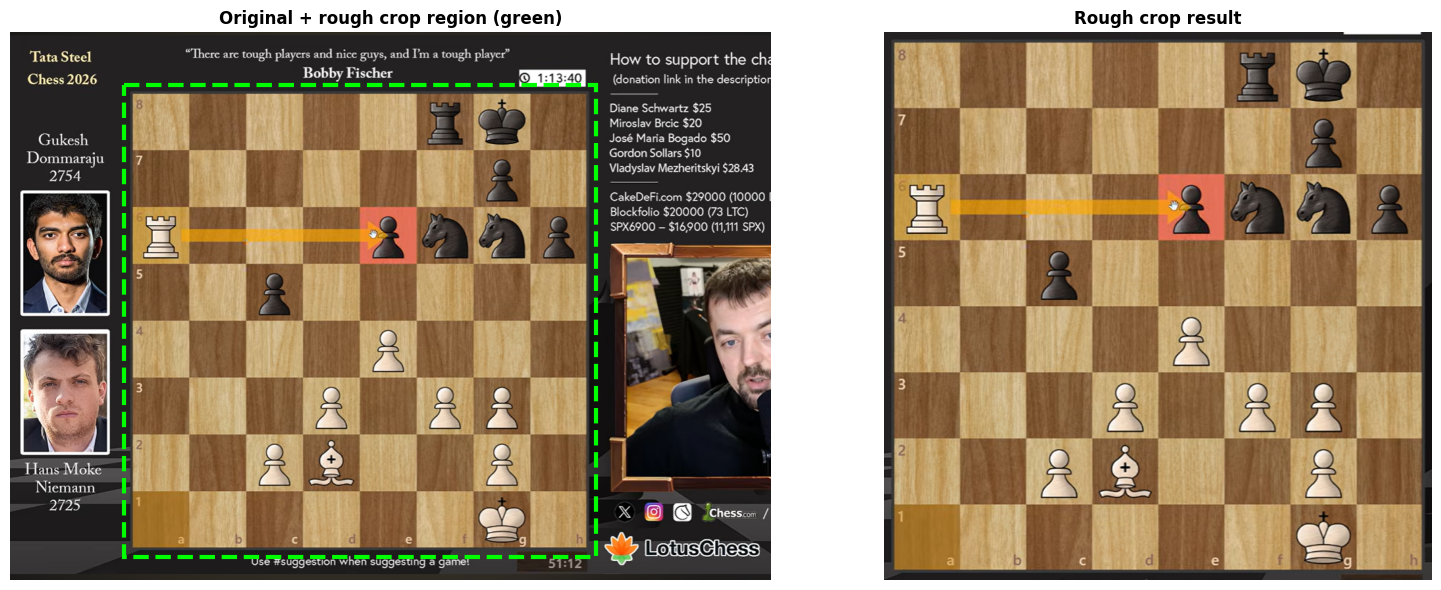

In [10]:
# Step 0: Rough crop — contour-based board isolation
print('STEP 0: Rough crop (contour-based board isolation)')
print('-' * 50)

image_orig = io.imread(IMAGE_PATH)
if image_orig.ndim == 3 and image_orig.shape[2] == 4:
    image_orig = image_orig[:, :, :3]

cropped_rough, (y_off, x_off), crop_found = rough_crop_board(image_orig)
print(f'Image size: {image_orig.shape[1]}x{image_orig.shape[0]}')
print(f'Crop found: {crop_found}')
if crop_found:
    print(f'Crop offset: x={x_off}, y={y_off}')
    print(f'Crop size: {cropped_rough.shape[1]}x{cropped_rough.shape[0]}')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: original with bounding box overlay
axes[0].imshow(image_orig)
axes[0].set_title('Original image', fontsize=12, fontweight='bold')
axes[0].axis('off')
if crop_found:
    ch, cw = cropped_rough.shape[:2]
    rect = Rectangle((x_off, y_off), cw, ch,
                     linewidth=3, edgecolor='lime', facecolor='none', linestyle='--')
    axes[0].add_patch(rect)
    axes[0].set_title('Original + rough crop region (green)', fontsize=12, fontweight='bold')

# Right: cropped result
axes[1].imshow(cropped_rough)
axes[1].set_title('Rough crop result' if crop_found else 'No crop (using full image)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Set image for subsequent steps
image = cropped_rough
h, w = image.shape[:2]

STEP 1: Histogram equalization on rough-cropped image
--------------------------------------------------
Working image size: 716x716


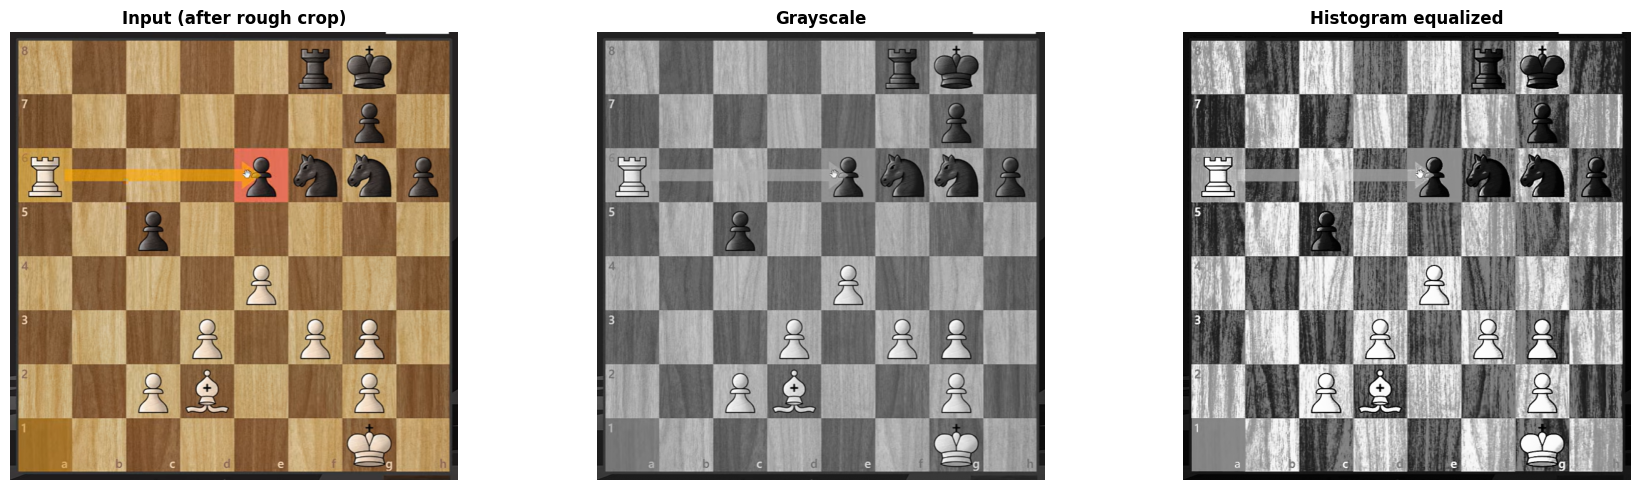

In [11]:
# Step 1: Preprocess (uses cropped image from Step 0)
print('STEP 1: Histogram equalization on rough-cropped image')
print('-' * 50)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
equ = cv2.equalizeHist(gray)
norm_image = equ.astype(np.float32) / 255.0

print(f'Working image size: {w}x{h}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(image)
axes[0].set_title('Input (after rough crop)', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Grayscale', fontsize=12, fontweight='bold')
axes[1].axis('off')
axes[2].imshow(equ, cmap='gray')
axes[2].set_title('Histogram equalized', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.tight_layout()
plt.show()

STEP 2: Sobel gradients (large kernel, ksize=31)
--------------------------------------------------
Large kernel smooths piece-level detail, emphasizes grid lines.


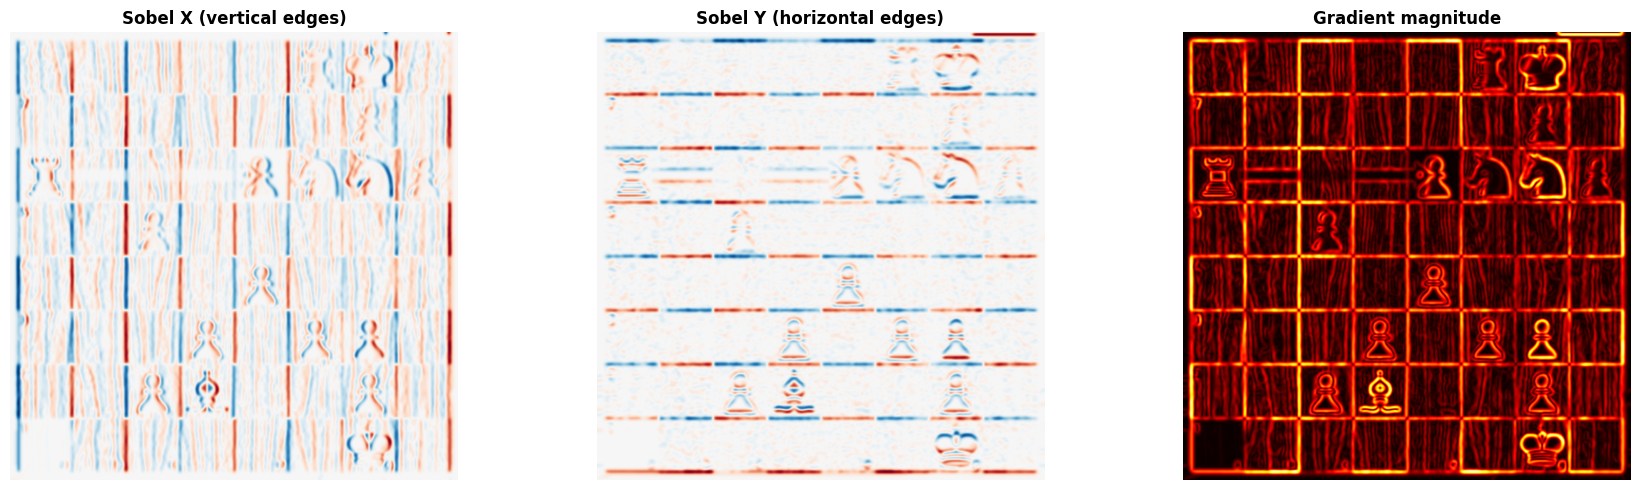

In [12]:
# Step 2: Compute Sobel gradients (ksize=31)
print('STEP 2: Sobel gradients (large kernel, ksize=31)')
print('-' * 50)
print('Large kernel smooths piece-level detail, emphasizes grid lines.')

grad_x = gradientx(norm_image)
grad_y = gradienty(norm_image)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(grad_x, cmap='RdBu', vmin=-np.abs(grad_x).max(), vmax=np.abs(grad_x).max())
axes[0].set_title('Sobel X (vertical edges)', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(grad_y, cmap='RdBu', vmin=-np.abs(grad_y).max(), vmax=np.abs(grad_y).max())
axes[1].set_title('Sobel Y (horizontal edges)', fontsize=12, fontweight='bold')
axes[1].axis('off')
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
axes[2].imshow(grad_mag, cmap='hot')
axes[2].set_title('Gradient magnitude', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.tight_layout()
plt.show()

STEP 3: Positive/negative gradient product projection
--------------------------------------------------
Split each gradient into positive (dark->light) and negative (light->dark).
Sum each along the axis, multiply them together.
Grid lines have BOTH transitions, so only they produce strong peaks.


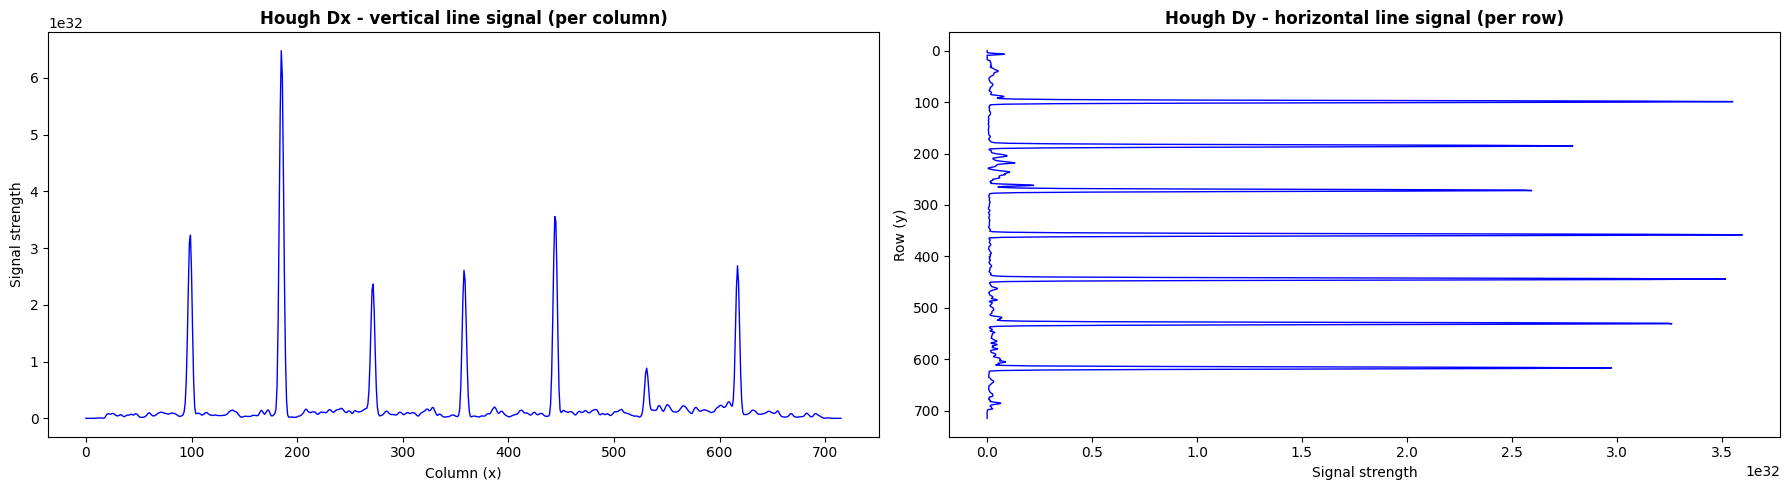

In [13]:
# Step 3: Positive/negative gradient split + Hough-like projection
print('STEP 3: Positive/negative gradient product projection')
print('-' * 50)
print('Split each gradient into positive (dark->light) and negative (light->dark).')
print('Sum each along the axis, multiply them together.')
print('Grid lines have BOTH transitions, so only they produce strong peaks.')

Dx_pos = np.clip(grad_x, 0, None).astype(np.float64)
Dx_neg = np.clip(-grad_x, 0, None).astype(np.float64)
Dy_pos = np.clip(grad_y, 0, None).astype(np.float64)
Dy_neg = np.clip(-grad_y, 0, None).astype(np.float64)

hough_Dx = (np.sum(Dx_pos, axis=0) * np.sum(Dx_neg, axis=0)) / (h ** 2)
hough_Dy = (np.sum(Dy_pos, axis=1) * np.sum(Dy_neg, axis=1)) / (w ** 2)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(hough_Dx, 'b-', linewidth=1)
axes[0].set_title('Hough Dx - vertical line signal (per column)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Column (x)')
axes[0].set_ylabel('Signal strength')

axes[1].plot(hough_Dy, range(len(hough_Dy)), 'b-', linewidth=1)
axes[1].set_title('Hough Dy - horizontal line signal (per row)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Signal strength')
axes[1].set_ylabel('Row (y)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

STEP 4: Adaptive thresholding + Gaussian blur + skeletonization
--------------------------------------------------
  Threshold level 1/5 (20%): found 7 vertical, 7 horizontal lines -> MATCH

Found 7+7 equally-spaced lines at threshold level 1/5


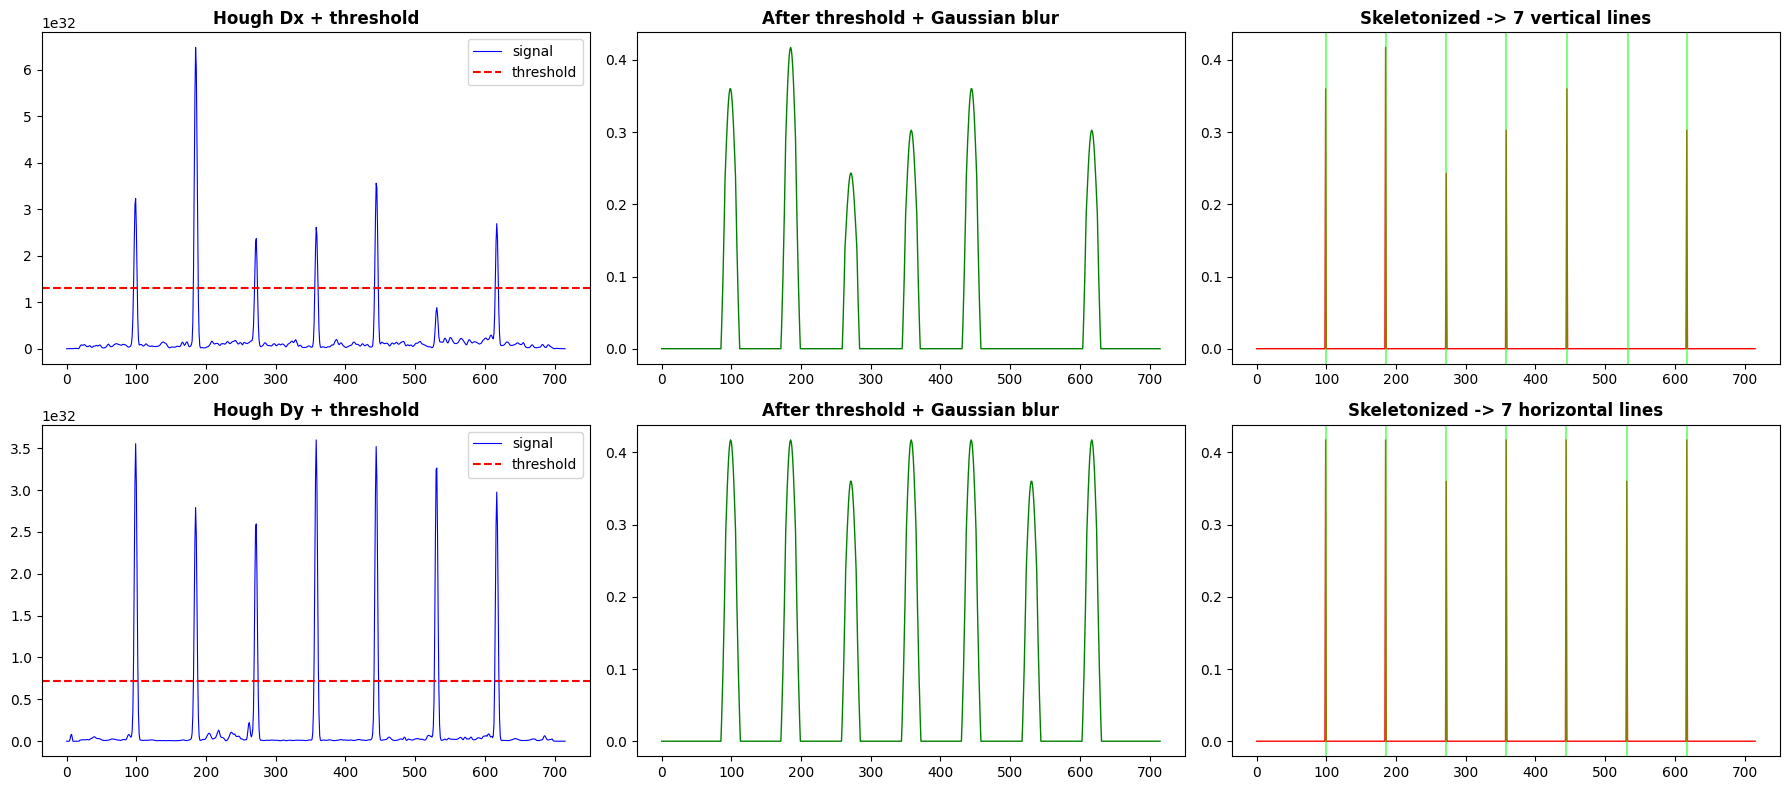

In [14]:
# Step 4: Adaptive threshold loop to find 7+7 grid lines
print('STEP 4: Adaptive thresholding + Gaussian blur + skeletonization')
print('-' * 50)

is_match = False
lines_x = []
lines_y = []
match_level = None

for a in range(1, 5):
    threshold_x = np.max(hough_Dx) * (a / 5.0)
    threshold_y = np.max(hough_Dy) * (a / 5.0)
    lines_x, lines_y, is_match = getChessLines(
        hough_Dx, hough_Dy, threshold_x, threshold_y, norm_image.shape
    )
    print(f'  Threshold level {a}/5 ({a*20}%): '
          f'found {len(lines_x)} vertical, {len(lines_y)} horizontal lines'
          f'{" -> MATCH" if is_match else ""}')
    if is_match:
        match_level = a
        # Refinement: try next threshold level and prefer it if it also matches
        if a < 4:
            next_tx = np.max(hough_Dx) * ((a + 1) / 5.0)
            next_ty = np.max(hough_Dy) * ((a + 1) / 5.0)
            next_lx, next_ly, next_match = getChessLines(
                hough_Dx, hough_Dy, next_tx, next_ty, norm_image.shape
            )
            if next_match:
                print(f'  -> Refined to threshold level {a+1}/5 '
                      f'({len(next_lx)} vertical, {len(next_ly)} horizontal)')
                lines_x, lines_y = next_lx, next_ly
                match_level = a + 1
        break

if is_match:
    print(f'\nFound 7+7 equally-spaced lines at threshold level {match_level}/5')
    
    # Show the threshold, blur, skeleton stages for the matched level
    threshold_x = np.max(hough_Dx) * (match_level / 5.0)
    threshold_y = np.max(hough_Dy) * (match_level / 5.0)
    
    gausswin = cv2.getGaussianKernel(21, 8.0, cv2.CV_64F).flatten()
    
    hdx_binary = np.where(hough_Dx > threshold_x, 1.0, 0.0)
    hdy_binary = np.where(hough_Dy > threshold_y, 1.0, 0.0)
    blur_x = np.convolve(hdx_binary, gausswin, mode='same')
    blur_y = np.convolve(hdy_binary, gausswin, mode='same')
    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    
    # Vertical lines (X direction) - top row
    axes[0, 0].plot(hough_Dx, 'b-', linewidth=0.8, label='signal')
    axes[0, 0].axhline(y=threshold_x, color='red', linestyle='--', label='threshold')
    axes[0, 0].set_title('Hough Dx + threshold', fontweight='bold')
    axes[0, 0].legend()
    
    axes[0, 1].plot(blur_x, 'g-', linewidth=1)
    axes[0, 1].set_title('After threshold + Gaussian blur', fontweight='bold')
    
    axes[0, 2].plot(skel_x, 'r-', linewidth=1)
    for lx in lines_x:
        axes[0, 2].axvline(x=lx, color='lime', alpha=0.5)
    axes[0, 2].set_title(f'Skeletonized -> {len(lines_x)} vertical lines', fontweight='bold')
    
    # Horizontal lines (Y direction) - bottom row
    axes[1, 0].plot(hough_Dy, 'b-', linewidth=0.8, label='signal')
    axes[1, 0].axhline(y=threshold_y, color='red', linestyle='--', label='threshold')
    axes[1, 0].set_title('Hough Dy + threshold', fontweight='bold')
    axes[1, 0].legend()
    
    axes[1, 1].plot(blur_y, 'g-', linewidth=1)
    axes[1, 1].set_title('After threshold + Gaussian blur', fontweight='bold')
    
    axes[1, 2].plot(skel_y, 'r-', linewidth=1)
    for ly in lines_y:
        axes[1, 2].axvline(x=ly, color='lime', alpha=0.5)
    axes[1, 2].set_title(f'Skeletonized -> {len(lines_y)} horizontal lines', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print('\nFAILED: Could not find 7+7 equally-spaced grid lines.')

STEP 5: Extend to full 9x9 grid + crop
--------------------------------------------------
7 interior lines + 2 outer edges = 9 lines per axis
Step size: 86x86 px
Board bbox: y=[13,703], x=[13,703]
Cropped: 690x690 px


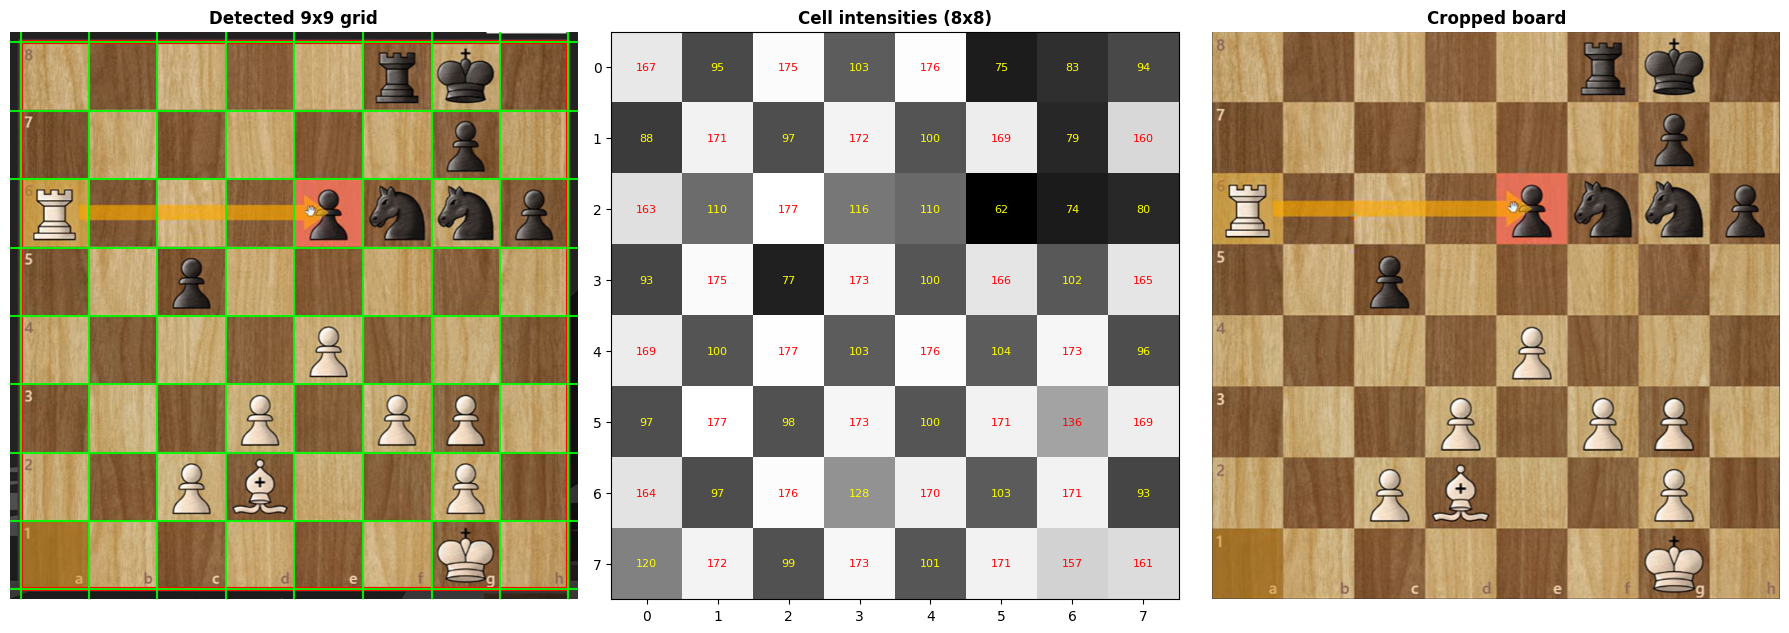

In [15]:
# Step 5: Extend to 9 lines, overlay grid, crop board
print('STEP 5: Extend to full 9x9 grid + crop')
print('-' * 50)

if not is_match:
    print('Skipped: no grid lines detected in previous step.')
else:
    stepx = int(round(np.mean(np.diff(lines_x))))
    stepy = int(round(np.mean(np.diff(lines_y))))
    
    all_x = [lines_x[0] - stepx] + lines_x + [lines_x[-1] + stepx]
    all_y = [lines_y[0] - stepy] + lines_y + [lines_y[-1] + stepy]
    
    x0 = max(0, all_x[0])
    x1 = min(w, all_x[-1])
    y0 = max(0, all_y[0])
    y1 = min(h, all_y[-1])
    
    print(f'7 interior lines + 2 outer edges = 9 lines per axis')
    print(f'Step size: {stepx}x{stepy} px')
    print(f'Board bbox: y=[{y0},{y1}], x=[{x0},{x1}]')
    
    cropped = image[y0:y1, x0:x1]
    print(f'Cropped: {cropped.shape[1]}x{cropped.shape[0]} px')
    
    # Cell intensity heatmap
    cell_means = np.zeros((8, 8), dtype=float)
    for r in range(8):
        for c in range(8):
            cy0, cy1 = max(0, all_y[r]), min(h, all_y[r + 1])
            cx0, cx1 = max(0, all_x[c]), min(w, all_x[c + 1])
            pad_y = max(1, (cy1 - cy0) // 6)
            pad_x = max(1, (cx1 - cx0) // 6)
            cell = gray[cy0+pad_y:cy1-pad_y, cx0+pad_x:cx1-pad_x]
            if cell.size > 0:
                cell_means[r, c] = cell.mean()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Grid overlay
    axes[0].imshow(image)
    for yy in all_y:
        axes[0].axhline(y=yy, color='lime', alpha=0.9, linewidth=1.5)
    for xx in all_x:
        axes[0].axvline(x=xx, color='lime', alpha=0.9, linewidth=1.5)
    rect = Rectangle((x0, y0), x1 - x0, y1 - y0,
                     linewidth=3, edgecolor='red', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title('Detected 9x9 grid', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Cell heatmap
    axes[1].imshow(cell_means, cmap='gray', interpolation='nearest')
    axes[1].set_title('Cell intensities (8x8)', fontsize=12, fontweight='bold')
    for r in range(8):
        for c in range(8):
            axes[1].text(c, r, f'{cell_means[r,c]:.0f}', ha='center', va='center',
                        color='red' if cell_means[r,c] > 128 else 'yellow', fontsize=8)
    
    # Cropped board
    axes[2].imshow(cropped)
    axes[2].set_title('Cropped board', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

STEP 6: Piece recognition + FEN
--------------------------------------------------


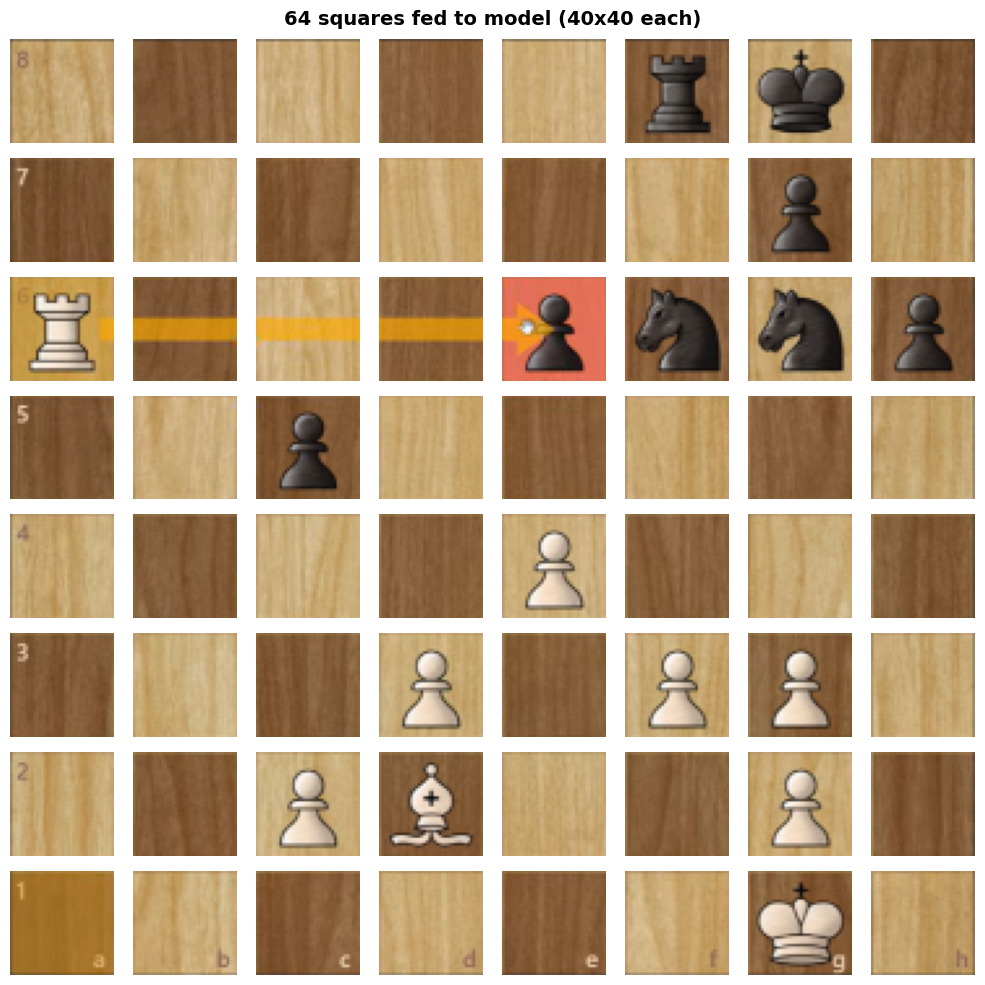

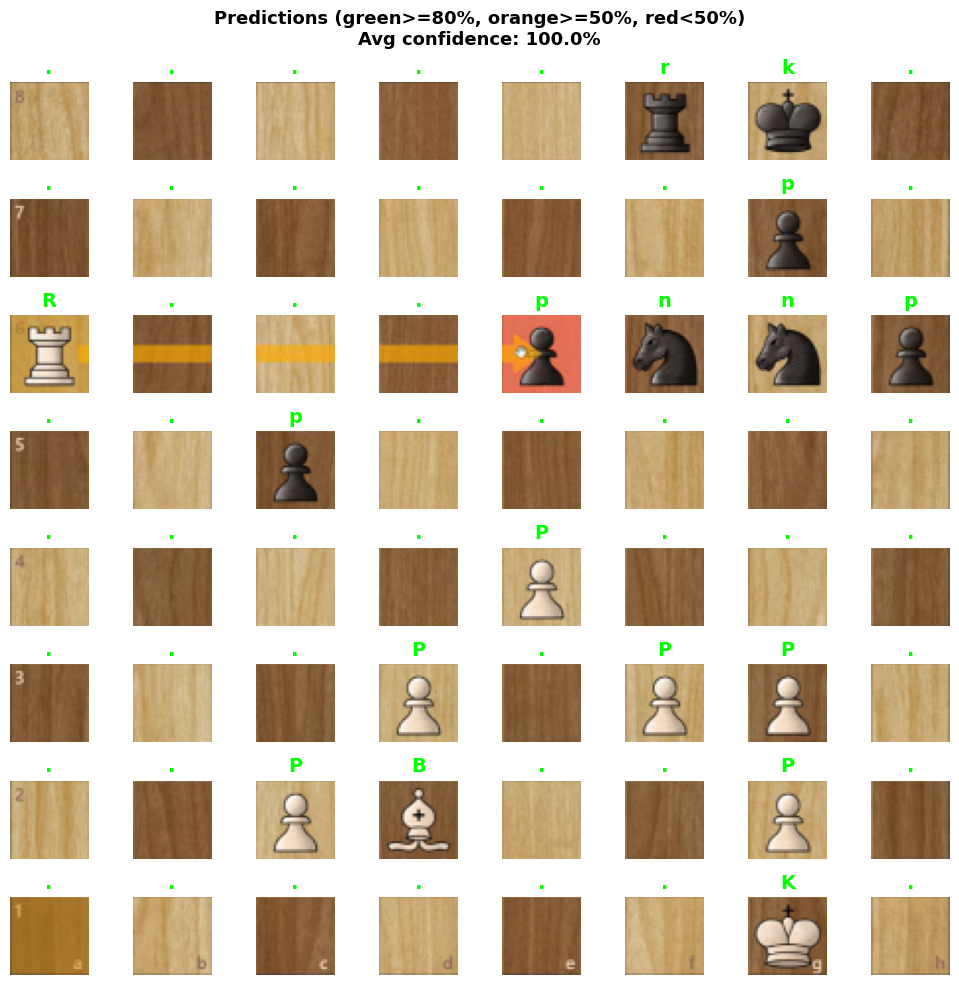


FEN: 5rk1-6p1-R3pnnp-2p5-4P3-3P1PP1-2PB2P1-6K1
Standard FEN: 5rk1/6p1/R3pnnp/2p5/4P3/3P1PP1/2PB2P1/6K1 w KQkq - 0 1
Confidence: avg=100.0%, min=100.0%

Lichess Editor:   https://lichess.org/editor/5rk1/6p1/R3pnnp/2p5/4P3/3P1PP1/2PB2P1/6K1_w_KQkq_-_0_1
Lichess Analysis: https://lichess.org/analysis/5rk1/6p1/R3pnnp/2p5/4P3/3P1PP1/2PB2P1/6K1_w_KQkq_-_0_1
Chess.com:        https://www.chess.com/analysis?fen=5rk1/6p1/R3pnnp/2p5/4P3/3P1PP1/2PB2P1/6K1%20w%20KQkq%20-%200%201


In [16]:
# Step 6: ML model prediction + FEN generation
print('STEP 6: Piece recognition + FEN')
print('-' * 50)

if not is_match:
    print('Skipped: no board detected.')
elif model is None:
    print('Skipped: no model loaded.')
else:
    squares = process_board_for_model(cropped)
    
    # Show the 64 squares
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for idx in range(64):
        r, c = idx // 8, idx % 8
        axes[r, c].imshow(squares[idx])
        axes[r, c].axis('off')
    plt.suptitle('64 squares fed to model (40x40 each)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Run predictions
    predictions = model.predict(squares, verbose=0)
    predicted_classes = predictions.argmax(axis=1)
    confidences = predictions.max(axis=1) / 3
    
    predicted_board = predicted_classes.reshape(8, 8)
    fen_simple = fen_from_onehot(predicted_board)
    fen_standard = simplified_fen_to_standard(fen_simple)
    
    avg_conf = confidences.mean()
    min_conf = confidences.min()
    
    # Show predictions on board
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for idx in range(64):
        r, c = idx // 8, idx % 8
        axes[r, c].imshow(squares[idx])
        piece_idx = predicted_classes[idx]
        label = piece_symbols[piece_idx] if piece_idx < 12 else '.'
        conf = confidences[idx]
        color = 'lime' if conf >= 0.8 else 'orange' if conf >= 0.5 else 'red'
        axes[r, c].set_title(label, fontsize=14, fontweight='bold', color=color)
        axes[r, c].axis('off')
    plt.suptitle(f'Predictions (green>=80%, orange>=50%, red<50%)\n'
                 f'Avg confidence: {avg_conf*100:.1f}%',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f'\nFEN: {fen_simple}')
    print(f'Standard FEN: {fen_standard}')
    print(f'Confidence: avg={avg_conf*100:.1f}%, min={min_conf*100:.1f}%')
    
    lichess_editor = create_lichess_link(fen_simple)
    lichess_analysis = create_lichess_analysis_link(fen_simple)
    chesscom = create_chesscom_link(fen_simple)
    
    print(f'\nLichess Editor:   {lichess_editor}')
    print(f'Lichess Analysis: {lichess_analysis}')
    print(f'Chess.com:        {chesscom}')
    
    low_conf = np.where(confidences < 0.80)[0]
    if len(low_conf) > 0:
        print(f'\nWARNING: {len(low_conf)} square(s) with confidence < 80%:')
        for idx in low_conf:
            row, col = idx // 8, idx % 8
            piece_idx = predicted_classes[idx]
            piece = piece_symbols[piece_idx] if piece_idx < 12 else 'empty'
            print(f'  [{row},{col}]: "{piece}" ({confidences[idx]*100:.1f}%)')